# Train a small transformer model on preprocessed segments

This notebook loads `segments_preproc_24.csv` produced by the preprocessing notebook, builds segment-level sequences, and trains a small transformer-based classifier.

In [12]:
# Imports and configuration
import os
import math
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

BASE_DATA_DIR = os.path.abspath("../data")
EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
PREPROC_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24.csv")

print("Using preprocessed file:", PREPROC_CSV)
assert os.path.exists(PREPROC_CSV), f"Preprocessed CSV not found: {PREPROC_CSV}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Using preprocessed file: /work/data/export/segments_preproc_24.csv
Device: cuda


In [13]:
# Set random seeds for reproducibility
import random
import numpy as np
import torch

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"Random seed locked to {SEED}")

Random seed locked to 1


In [14]:
# Load preprocessed dataset and build segment-level sequences
df = pd.read_csv(PREPROC_CSV)
print("Raw preprocessed shape:", df.shape)

# Ensure correct ordering within each segment
df = df.sort_values(["segment_id", "seq_pos"], kind="mergesort").reset_index(drop=True)

feature_cols = [c for c in df.columns if c not in ["segment_id", "label", "csv_file", "seq_pos"]]
print("Feature columns (", len(feature_cols), "):", feature_cols)

# Group into (segment, sequence of length 24, label)
segments = []
labels = []

for seg_id, g in df.groupby("segment_id", sort=True):
    g = g.sort_values("seq_pos", kind="mergesort")
    feat = g[feature_cols].to_numpy(dtype=np.float32)
    # Expect 24 steps; if shorter/longer, adjust with simple strategies
    if feat.shape[0] < 24:
        # pad by repeating last step
        pad = np.repeat(feat[-1:, :], 24 - feat.shape[0], axis=0)
        feat = np.concatenate([feat, pad], axis=0)
    elif feat.shape[0] > 24:
        # truncate extra steps
        feat = feat[:24, :]

    assert feat.shape[0] == 24, feat.shape
    segments.append(feat)
    labels.append(g["label"].iloc[0])

X = np.stack(segments, axis=0)  # (N, 24, F)
y = np.array(labels)

print("Num segments:", X.shape[0], "Seq len:", X.shape[1], "Num features:", X.shape[2])
print("Label distribution:")
print(pd.Series(y).value_counts())

Raw preprocessed shape: (3456, 12)
Feature columns ( 8 ): ['open_norm', 'high_norm', 'low_norm', 'close_norm', 'vol_close', 'vol_high_low', 'compression_ratio', 'trend']
Num segments: 144 Seq len: 24 Num features: 8
Label distribution:
Bullish Normal     40
Bearish Normal     27
Bearish Pennant    26
Bullish Pennant    22
Bullish Wedge      15
Bearish Wedge      14
Name: count, dtype: int64


In [15]:
# Encode labels as integers
label_values = np.sort(pd.unique(y))
label_to_idx = {lbl: i for i, lbl in enumerate(label_values)}
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}

y_idx = np.vectorize(label_to_idx.get)(y)
num_classes = len(label_values)
print("Classes:", label_values, "-> num_classes =", num_classes)

Classes: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge'] -> num_classes = 6


In [16]:
# Train/validation split at segment level
X_train, X_val, y_train, y_val = train_test_split(
    X, y_idx, test_size=0.2, random_state=SEED, stratify=y_idx,
 )

print("Train segments:", X_train.shape[0])
print("Val segments:", X_val.shape[0])

class SegmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (N, T, F)
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SegmentDataset(X_train, y_train)
val_ds = SegmentDataset(X_val, y_val)

batch_size = 12
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

len(train_loader), len(val_loader)

Train segments: 115
Val segments: 29


(10, 3)

In [17]:
# Extended CNN-based classifier for pattern recognition
class SimpleCNN(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, hidden_channels: int = 64):
        super().__init__()
        # Input: (B, T, F) -> rearrange to (B, F, T) for Conv1d
        self.conv = nn.Sequential(
            # Block 1
            nn.Conv1d(in_channels=input_dim, out_channels=hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            # Block 2
            nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            # Block 3
            nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            # Block 4
            nn.Conv1d(in_channels=hidden_channels * 2, out_channels=hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)  # global average over time
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, num_classes),
        )
        # Apply Xavier initialization for better stability
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):  # x: (B, T, F)
        x = x.transpose(1, 2)  # (B, F, T)
        h = self.conv(x)
        h = self.pool(h).squeeze(-1)  # (B, C)
        logits = self.fc(h)
        return logits

model = SimpleCNN(input_dim=X.shape[2], num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler for better convergence
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

SimpleCNN(
  (conv): Sequential(
    (0): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
 

In [18]:
# Training loop using the extended CNN
from sklearn.metrics import f1_score

def run_epoch(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    total_loss = 0.0
    all_preds = []
    all_targets = []

    if is_train:
        model.train()
    else:
        model.eval()

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        with torch.set_grad_enabled(is_train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')
    return avg_loss, acc, f1

# Create checkpoint directory
checkpoint_dir = os.path.join(EXPORT_DIR, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)
print(f"Checkpoints will be saved to: {checkpoint_dir}")

num_epochs = 30  # More epochs for deeper model
best_val_f1 = 0.0
best_checkpoint_path = None

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc, train_f1 = run_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc, val_f1 = run_epoch(val_loader, model, criterion, optimizer=None)
    scheduler.step()
    
    # Save checkpoint if validation F1 score improved
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_marker = " *"
        
        # Save the best model checkpoint
        best_checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch{epoch:02d}_f1{val_f1:.4f}.pt")
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'best_val_f1': best_val_f1,
            'label_to_idx': label_to_idx,
            'idx_to_label': idx_to_label,
            'num_classes': num_classes,
            'input_dim': X.shape[2],
        }
        torch.save(checkpoint, best_checkpoint_path)
        print(f"Saved best checkpoint: {os.path.basename(best_checkpoint_path)}")
    else:
        best_marker = ""
    
    lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:02d} | lr={lr:.6f} | train_loss={train_loss:.4f} acc={train_acc:.4f} f1={train_f1:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}{best_marker}")

print(f"\nBest validation F1 score: {best_val_f1:.4f}")
print(f"Best checkpoint saved at: {best_checkpoint_path}")

Checkpoints will be saved to: /work/data/export/checkpoints


Saved best checkpoint: best_model_epoch01_f10.0721.pt
Epoch 01 | lr=0.000994 | train_loss=1.7466 acc=0.2609 f1=0.1453 | val_loss=1.7443 acc=0.2759 f1=0.0721 *
Saved best checkpoint: best_model_epoch02_f10.1549.pt
Epoch 02 | lr=0.000976 | train_loss=1.5908 acc=0.3217 f1=0.1503 | val_loss=1.6812 acc=0.3448 f1=0.1549 *
Saved best checkpoint: best_model_epoch02_f10.1549.pt
Epoch 02 | lr=0.000976 | train_loss=1.5908 acc=0.3217 f1=0.1503 | val_loss=1.6812 acc=0.3448 f1=0.1549 *
Saved best checkpoint: best_model_epoch03_f10.2470.pt
Epoch 03 | lr=0.000946 | train_loss=1.4862 acc=0.4435 f1=0.2520 | val_loss=1.6236 acc=0.4483 f1=0.2470 *
Epoch 04 | lr=0.000905 | train_loss=1.3745 acc=0.4783 f1=0.3309 | val_loss=1.5752 acc=0.4138 f1=0.2321
Saved best checkpoint: best_model_epoch03_f10.2470.pt
Epoch 03 | lr=0.000946 | train_loss=1.4862 acc=0.4435 f1=0.2520 | val_loss=1.6236 acc=0.4483 f1=0.2470 *
Epoch 04 | lr=0.000905 | train_loss=1.3745 acc=0.4783 f1=0.3309 | val_loss=1.5752 acc=0.4138 f1=0.2321

In [19]:
# Load the best checkpoint
if best_checkpoint_path and os.path.exists(best_checkpoint_path):
    print(f"Loading best checkpoint from: {best_checkpoint_path}")
    checkpoint = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
    
    # Restore model state
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"\nBest model loaded from epoch {checkpoint['epoch']}")
    print(f"  Train accuracy: {checkpoint['train_acc']:.4f}")
    print(f"  Train F1: {checkpoint['train_f1']:.4f}")
    print(f"  Val accuracy: {checkpoint['val_acc']:.4f}")
    print(f"  Val F1: {checkpoint['val_f1']:.4f}")
    print(f"  Val loss: {checkpoint['val_loss']:.4f}")
    
    model.eval()
else:
    print("No checkpoint found - using final training state")

Loading best checkpoint from: /work/data/export/checkpoints/best_model_epoch06_f10.3181.pt

Best model loaded from epoch 6
  Train accuracy: 0.4609
  Train F1: 0.3136
  Val accuracy: 0.4483
  Val F1: 0.3181
  Val loss: 1.5369


Train accuracy: 0.5304
Train F1 (macro): 0.3927
Val accuracy: 0.4483
Val F1 (macro): 0.3181


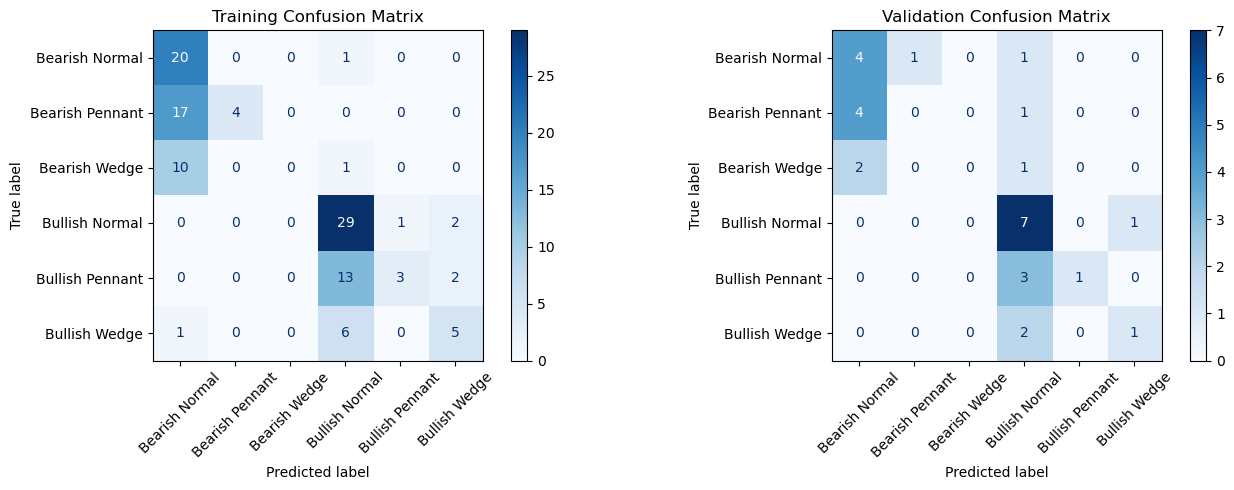


Classification report (validation):
                 precision    recall  f1-score   support

 Bearish Normal       0.40      0.67      0.50         6
Bearish Pennant       0.00      0.00      0.00         5
  Bearish Wedge       0.00      0.00      0.00         3
 Bullish Normal       0.47      0.88      0.61         8
Bullish Pennant       1.00      0.25      0.40         4
  Bullish Wedge       0.50      0.33      0.40         3

       accuracy                           0.45        29
      macro avg       0.39      0.35      0.32        29
   weighted avg       0.40      0.45      0.37        29



/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

In [20]:
# Final evaluation and per-class metrics on validation set
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

model.eval()

def get_predictions(loader):
    all_preds = []
    all_targets = []
    for xb, yb in loader:
        xb = xb.to(device)
        with torch.no_grad():
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())
    return np.concatenate(all_preds), np.concatenate(all_targets)

# Get predictions for train and validation sets
train_preds, train_targets = get_predictions(train_loader)
val_preds, val_targets = get_predictions(val_loader)

train_acc = accuracy_score(train_targets, train_preds)
train_f1 = f1_score(train_targets, train_preds, average='macro')
val_acc = accuracy_score(val_targets, val_preds)
val_f1 = f1_score(val_targets, val_preds, average='macro')

print(f"Train accuracy: {train_acc:.4f}")
print(f"Train F1 (macro): {train_f1:.4f}")
print(f"Val accuracy: {val_acc:.4f}")
print(f"Val F1 (macro): {val_f1:.4f}")

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training confusion matrix
cm_train = confusion_matrix(train_targets, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label_values)
disp_train.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title("Training Confusion Matrix")

# Validation confusion matrix
cm_val = confusion_matrix(val_targets, val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_values)
disp_val.plot(ax=axes[1], cmap='Blues', xticks_rotation=45)
axes[1].set_title("Validation Confusion Matrix")

plt.tight_layout()
plt.show()

# Classification report for validation
print("\nClassification report (validation):")
print(classification_report(val_targets, val_preds, target_names=[str(lbl) for lbl in label_values]))

In [21]:
# Reload the baseline_model module to pick up any changes
import importlib
import sys

# Remove cached module if it exists
if 'baseline_model' in sys.modules:
    del sys.modules['baseline_model']

# Re-import
import baseline_model
print("Baseline model reloaded with current slope_threshold:", baseline_model.BaselineModel().slope_threshold)

Baseline model reloaded with current slope_threshold: 0.0002


In [22]:
# Evaluate baseline model on the combined segments CSV and plot confusion matrix
import os
from baseline_model import predict_from_segments_csv, evaluate_on_segments_csv

# Path to the combined segment CSV produced by 01-data-exploration.ipynb
segments_csv_path = os.path.abspath("../data/export/segments_values.csv")
print("Using segments CSV for baseline:", segments_csv_path)

# Custom slope threshold for baseline model
BASELINE_SLOPE_THRESHOLD = 0.0002

# Run baseline model on all segments; this returns a DataFrame
baseline_results = predict_from_segments_csv(segments_csv_path, slope_threshold=BASELINE_SLOPE_THRESHOLD)
print("Baseline results shape:", baseline_results.shape)
print(f"Using slope_threshold: {BASELINE_SLOPE_THRESHOLD}")

# Keep only rows with ground-truth labels
mask = baseline_results["gold_label"].notna()
baseline_labels = baseline_results.loc[mask, "gold_label"].values
baseline_preds = baseline_results.loc[mask, "predicted_label"].values

print("Number of evaluated segments:", baseline_labels.shape[0])

# Print accuracy, F1 score, and classification report
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
baseline_acc = accuracy_score(baseline_labels, baseline_preds)
baseline_f1 = f1_score(baseline_labels, baseline_preds, average='macro')
print(f"Baseline accuracy: {baseline_acc:.4f}")
print(f"Baseline F1 score (macro): {baseline_f1:.4f}")

# Use label set from the baseline outputs
import numpy as np
baseline_label_values = np.sort(pd.unique(baseline_labels))
print("Baseline classes:", baseline_label_values)

print("\nClassification report (baseline):")
print(classification_report(baseline_labels, baseline_preds,
                            labels=baseline_label_values,
                            target_names=[str(lbl) for lbl in baseline_label_values]))

# Plot confusion matrix for baseline model
import matplotlib.pyplot as plt
cm_baseline = confusion_matrix(baseline_labels, baseline_preds, labels=baseline_label_values)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=baseline_label_values)
fig, ax = plt.subplots(figsize=(6, 5))
disp_baseline.plot(ax=ax, cmap="Oranges", xticks_rotation=45)
ax.set_title(f"Baseline Model Confusion Matrix (threshold={BASELINE_SLOPE_THRESHOLD})")
plt.tight_layout()
plt.show()

Using segments CSV for baseline: /work/data/export/segments_values.csv


ValueError: Missing required OHLC columns: ['Open', 'High', 'Low', 'Close']

Confusion matrix classes (ordered): ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']


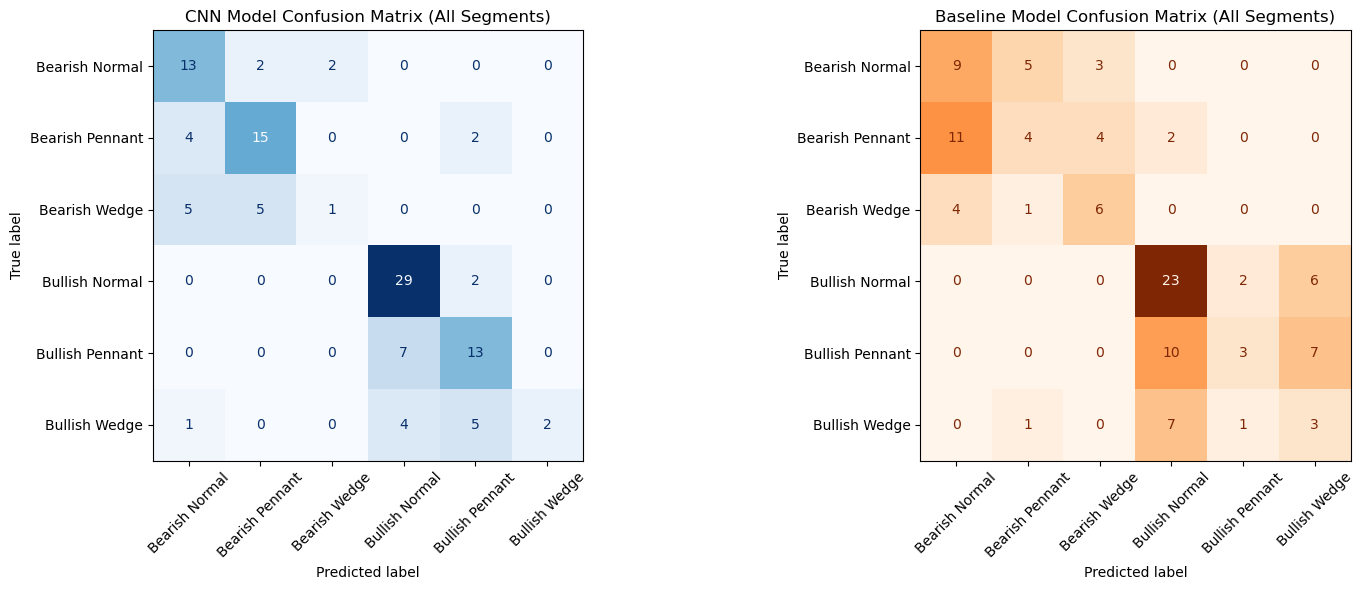

In [ ]:
# Compare confusion matrices of CNN model vs baseline on all segments
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) CNN model predictions on all segments used for training
full_ds = SegmentDataset(X, y_idx)
full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False)

cnn_preds_all, cnn_targets_all = get_predictions(full_loader)

# Map integer indices back to label strings
cnn_true_labels = np.vectorize(idx_to_label.get)(cnn_targets_all)
cnn_pred_labels = np.vectorize(idx_to_label.get)(cnn_preds_all)

# 2) Baseline predictions (already computed from segments_values.csv)
#    Using baseline_labels and baseline_preds from the previous cell

# Use the global label set from the CNN pipeline for consistent ordering
all_labels = label_values
print("Confusion matrix classes (ordered):", all_labels)

cm_cnn_all = confusion_matrix(cnn_true_labels, cnn_pred_labels, labels=all_labels)
cm_baseline_all = confusion_matrix(baseline_labels, baseline_preds, labels=all_labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CNN confusion matrix
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_all, display_labels=all_labels)
cnn_disp.plot(ax=axes[0], cmap="Blues", xticks_rotation=45, colorbar=False)
axes[0].set_title("CNN Model Confusion Matrix (All Segments)")

# Baseline confusion matrix
base_disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_all, display_labels=all_labels)
base_disp.plot(ax=axes[1], cmap="Oranges", xticks_rotation=45, colorbar=False)
axes[1].set_title("Baseline Model Confusion Matrix (All Segments)")

plt.tight_layout()
plt.show()